<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/visualizing_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U gdown -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [ ]:
RESOLUTION = 224
PATCH_SIZE = 16

In [ ]:
crop_layer = keras.layers.CenterCrop(RESOLUTION,RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean = [0.485 *255 ,0.456*255,0.406*255],
    variance = [(0.229*255)**2 , (0.224*255)**2 ,(0.225*255)**2]
)
rescale_layer = keras.layers.Rescaling(scale =1.0/127.5, offset =-1)

def preprocess_image(image , model_type , size = RESOLUTION):
  image = np.array(image)
  image = np.expand_dims(image,0)
  if model_type  == "original_vit":
    image = rescale_layer(image)
  resize_size = int((256/224)* size)
  image =  tf.image.resize(image,(resize_size,resize_size), method ='bicubic')
  image = crop_layer(image)
  if model_type != "original_vit":
    image = norm_layer(image)

  return image.numpy()

def load_image_from_url(url,model_type):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  preprocessed_image =  preprocess_image(image,model_type)
  return image ,preprocessed_image

32768/21675 [=============================================] - 0s 0us/step


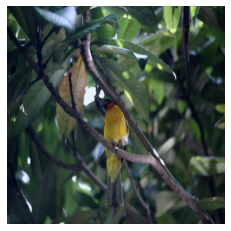

In [ ]:
mapping_file = keras.utils.get_file(origin ="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt")
with open(mapping_file,"r") as f:
  lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]
image_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image,preprocessed_image = load_image_from_url(image_url,"original_vit")
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model


vit_base_i21k_patch16_224 = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")
print("Model loaded.")

Downloading...
From: https://drive.google.com/uc?id=1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ
To: /content/vit_b16_patch16_224.zip
100%|██████████| 322M/322M [00:01<00:00, 175MB/s]


Model loaded.


In [ ]:
predictions,attention_score_dict = vit_base_i21k_patch16_224.predict(preprocessed_image)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]

In [ ]:
predicted_label

'bulbul'

In [ ]:
attention_score_dict.keys()

dict_keys(['transformer_block_11_att', 'transformer_block_9_att', 'transformer_block_2_att', 'transformer_block_6_att', 'transformer_block_7_att', 'transformer_block_1_att', 'transformer_block_3_att', 'transformer_block_4_att', 'transformer_block_10_att', 'transformer_block_0_att', 'transformer_block_5_att', 'transformer_block_8_att'])

In [ ]:
int(1/6)

0

In [ ]:
def compute_distance_matrix(patch_size,num_patches,length):
  distance_matrix = np.zeros((num_patches,num_patches))
  for i in range(num_patches):
    for j in range(num_patches):
      if i == j:
        continue
      xi,yi = (int(i/length)) ,(i%length)
      xj,yj = (int(j/length)) ,(j%length)
      distance_matrix[i,j] = patch_size * np.linalg.norm([xi-xj,yi-yj])
  
  return distance_matrix
def compute_mean_attention_dist(patch_size,attention_weights,model_type):
  num_cls_tokens = 2 if "distilled" in model_type else 1
  
  attention_weights = attention_weights[... , num_cls_tokens:,num_cls_tokens:]
  num_patches = attention_weights.shape[-1]
  length = int(np.sqrt(num_patches))
  
  assert length**2 == num_patches ,"num_patches is not perfect square"
  
  distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
  h,w = distance_matrix.shape
  
  distance_matrix = distance_matrix.reshape(1,1,h,w)

  mean_distances = attention_weights * distance_matrix

  mean_distance = np.sum(mean_distances , axis =-1)
  mean_distance = np.mean(mean_distance , axis =-1)
  print(mean_distances.shape)
  return mean_distance

In [ ]:
mean_distances = {
    f"{name}_mean_dist" : compute_mean_attention_dist(
        patch_size = PATCH_SIZE,
        attention_weights = attention_weight,
        model_type ='original_vit',
    )
    for name ,attention_weight in attention_score_dict.items()

}

num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()


(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)
(1, 12, 196, 196)


Num Heads: 12.


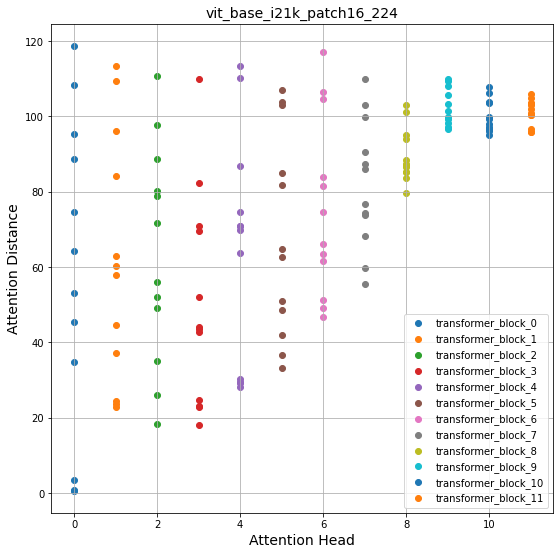

In [ ]:

print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

In [ ]:
def attention_rollout_map(image,attention_score_dict,model_type):
  num_cls_token = 2 if "distilled" in model_type else 1
  attn_mat = np.stack = ([attention_score_dict[k] for k in attention_score_dict.keys()])
  attn_mat = np.squeeze(attn_mat,axis =1)

  attn_mat = tf.reduce_mean(attn_mat , axis =1)

  residual_attn = np.eye(attn_mat.shape[1])
  aug_attn_mat = attn_mat+ residual_attn
  aug_attn_mat  = aug_attn_mat /tf.reduce_sum(aug_attn_mat,axis=-1)[...,None]
  joint_attentions = np.zeros(aug_attn_mat.shape)
  joint_attentions[0] = aug_attn_mat[0]

  for n in range(1, aug_attn_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
  mask = v[0,num_cls_token:].reshape(grid_size,grid_size)
  mask =cv2.resize(mask/mask.max() , image.size)[... , np.newaxis]
  result = (mask*image).astype("uint8")
  return result





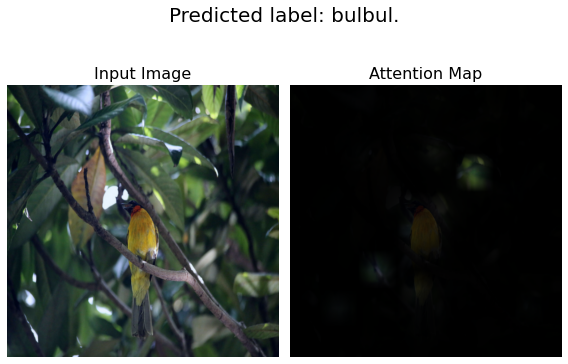

In [ ]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

In [ ]:
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("loaded_model")

image_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image,preprocessed_image = load_image_from_url(image_url, model_type="dino")

prdictions,attention_score_dict = vit_dino_base16.predict(preprocessed_image)


Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:04<00:00, 77.8MB/s]


loaded_model


In [ ]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

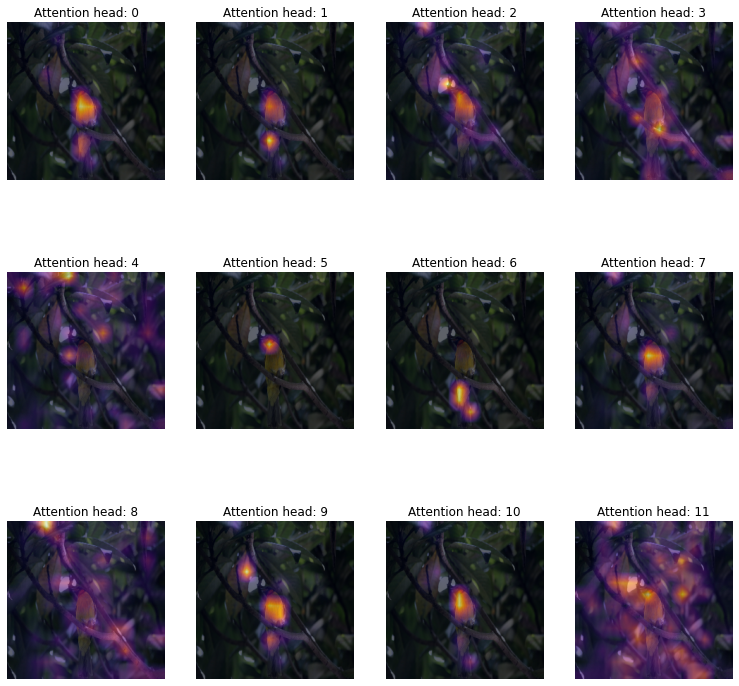

In [ ]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

In [ ]:
projections.shape

(16, 16, 3, 768)

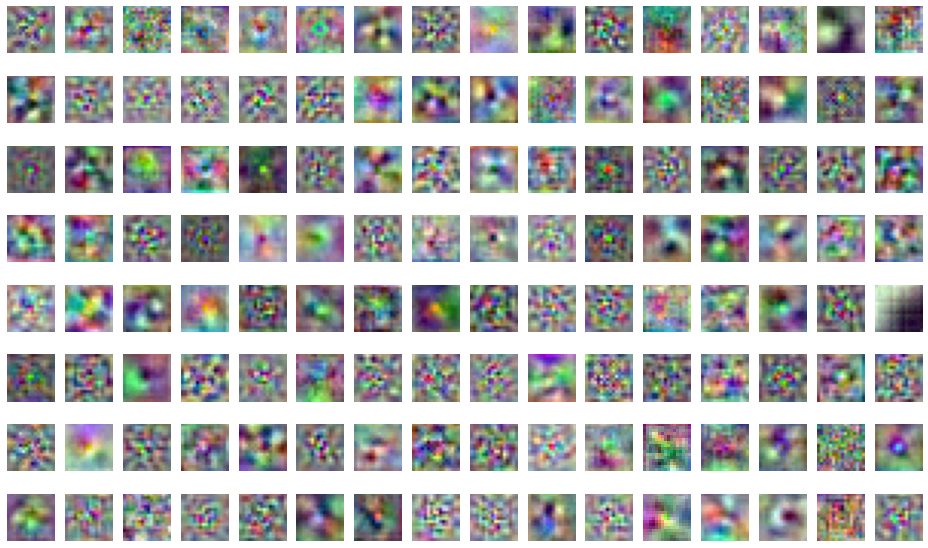

In [ ]:
projections = (
    vit_base_i21k_patch16_224.layers[1].get_layer("projection").get_layer("conv_projection").kernel.numpy()
)

projection_dim = projections.shape[-1]
patch_h,patch_w,patch_channels = projections.shape[:-1]

scaled_projections = MinMaxScaler().fit_transform(projections.reshape(-1,projection_dim))

scaled_projections = scaled_projections.reshape(patch_h,patch_w,patch_channels,-1)

fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()


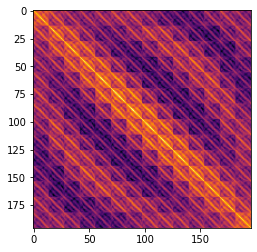

In [ ]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

position_embeddings = position_embeddings.squeeze()[1:,...]
similarity = position_embeddings @ position_embeddings.T

plt.imshow(similarity, cmap="inferno")
plt.show()

In [ ]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()